In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyeem

In [15]:
pyeem.instruments.supported

name
manufacturer supported_models              
Agilent      Cary 4E                cary_4e
             Cary Eclipse      cary_eclipse
Horiba       Aqualog-880-C          aqualog
             SPEX Fluorolog-3     fluorolog
Tecan        Spark                    spark

In [16]:
data_dir = "../../../../local_test_data/qinmin"
calibration_sources = {
    "chloropyhll": "ug/L",
}

dataset = pyeem.datasets.Dataset(
    data_dir=data_dir,
    calibration_sources=calibration_sources,
    raman_instrument="cary_eclipse",
    absorbance_instrument=None,
    eem_instrument="cary_eclipse"
)

In [17]:
display(dataset.meta_df)

datetime_utc         filename  \
sample_set scan_type                                         
1          sample_eem 2020-07-29 10:30:00  sample_eem1.csv   
2          sample_eem 2020-07-29 10:45:00  sample_eem1.csv   
3          blank_eem  2020-08-04 11:00:00   blank_eem1.csv   
           sample_eem 2020-08-04 12:00:00  sample_eem1.csv   
           sample_eem 2020-08-04 13:00:00  sample_eem2.csv   

                                                        description comments  \
sample_set scan_type                                                           
1          sample_eem  Emission: [500, 800], Excitation: [400, 425]            
2          sample_eem  Emission: [560, 800], Excitation: [480, 516]            
3          blank_eem                          PMT voltage (V): High            
           sample_eem                       PMT voltage (V): Medium            
           sample_eem                         PMT voltage (V): High            

                      collected_by  dilution  chloropyhll  phycocyanin  \
sample_set scan_type                                                     
1          sample_eem         Anna       1.0          0.0          NaN   
2          sample_eem         Anna       1.0          0.0          NaN   
3          blank_eem                     1.0          0.0          NaN   
           sample_eem         Anna       1.0        600.0          NaN   
           sample_eem         Anna       1.0       6000.0          NaN   

                       fucoxanthin  calibration_sample  prototypical_sample  \
sample_set scan_type                                                          
1          sample_eem          NaN               False                False   
2          sample_eem          NaN               False                False   
3          blank_eem           NaN               False                False   
           sample_eem          NaN                True                False   
           sample_eem          NaN                True                False   

                       test_sample  \
sample_set scan_type                 
1          sample_eem        False   
2          sample_eem        False   
3          blank_eem         False   
           sample_eem        False   
           sample_eem        False   

                                                                filepath  \
sample_set scan_type                                                       
1          sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   
2          sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   
3          blank_eem   /home/roboat/Documents/roboat/PyEEM/local_test...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/local_test...   

                              name                       hdf_path  
sample_set scan_type                                               
1          sample_eem  sample_eem1  raw_sample_sets/1/sample_eem1  
2          sample_eem  sample_eem1  raw_sample_sets/2/sample_eem1  
3          blank_eem    blank_eem1   raw_sample_sets/3/blank_eem1  
           sample_eem  sample_eem1  raw_sample_sets/3/sample_eem1  
           sample_eem  sample_eem2  raw_sample_sets/3/sample_eem2

In [18]:
routine_df = pyeem.preprocessing.create_routine(
    crop=False,
    blank_subtraction=True,
    scatter_removal=True,
)
display(routine_df)

,step_name,hdf_path
step_order,,
0,raw,raw_sample_sets/
1,blank_subtraction,preprocessing/corrections/blank_subtraction
2,scatter_removal,preprocessing/corrections/scatter_removal
3,complete,preprocessing/complete/


In [19]:
# Just an example crop dim
crop_dims = {"emission_bounds": (-np.inf, np.inf), "excitation_bounds": (-np.inf, np.inf)}

# Keep everything
#crop_dims = {"emission_bounds": (-np.inf, np.inf), "excitation_bounds": (-np.inf, np.inf)}

# microcystis peak
#crop_dims = {"emission_bounds": (640, 650),"excitation_bounds": (610, 630)}

# chlorella peak
#crop_dims = {"emission_bounds": (600, 800),"excitation_bounds": (-np.inf, 750)}

kwargs = {
    "crop_dims": crop_dims,
    "band": "both",
    "order": "both",
    "excision_width": 40,
    "fill": "interp"
}

routine_results_df = pyeem.preprocessing.perform_routine(
    dataset, routine_df, progress_bar=True, **kwargs
)
#display(routine_results_df)

Preprocessing scan sets: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


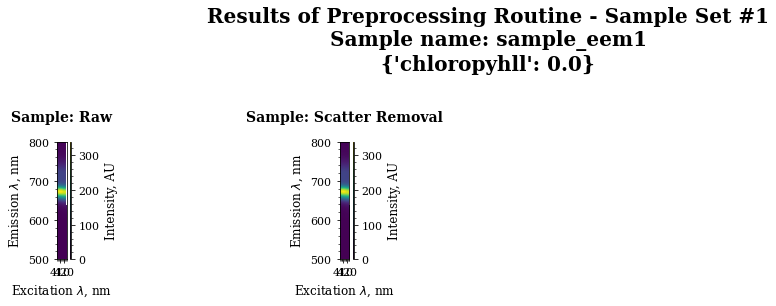

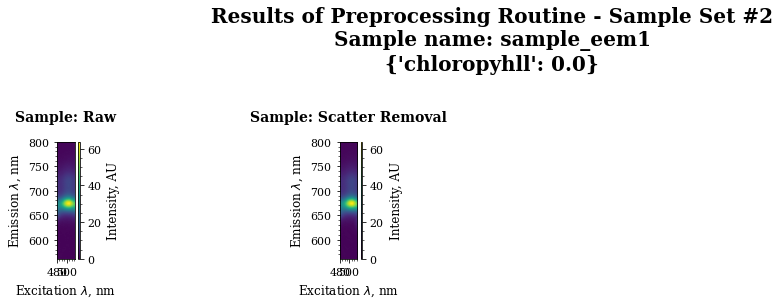

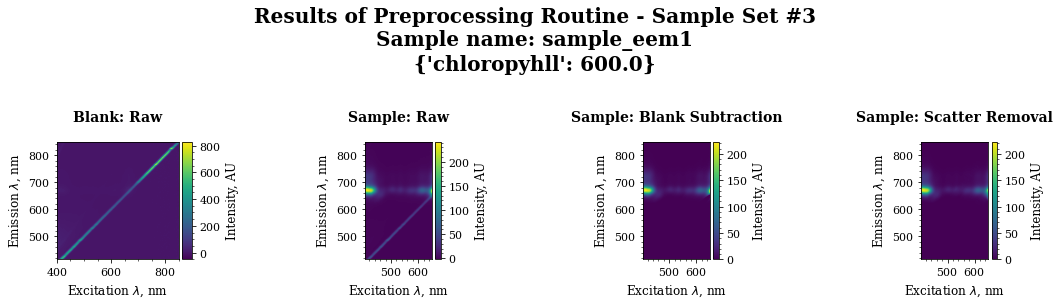

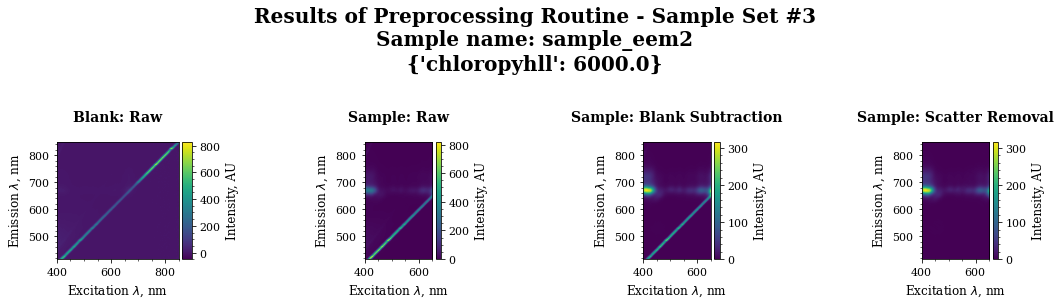

In [20]:
for group_name, group in dataset.meta_df.groupby(["sample_set", "name"]):
    try:
        sample_set = group_name[0]
        sample_name = group_name[1]
        if "sample_eem" not in sample_name:
            continue

        # Custom suptitle for the plot to be passed as kwarg
        title = dict(zip(
            dataset.calibration_sources.keys(),
            group[dataset.calibration_sources.keys()].values[0]
        ))
        suptitle = "Results of Preprocessing Routine - Sample Set #{0}\nSample name: {1}".format(
            sample_set, sample_name
        )
        suptitle += "\n" + str(title)

        pyeem.plots.preprocessing.plot_preprocessing(
            dataset, 
            routine_results_df,
            sample_set,
            sample_name,
            plot_type="imshow",
            suptitle = suptitle
        )
        plt.show()
    except:
        pass

In [21]:
cal_df = pyeem.preprocessing.calibration(
    dataset, routine_results_df
)

In [22]:
display(cal_df)

concentration  \
source      source_units intensity_units measurement_units        slope     intercept     r_squared                  
chloropyhll ug/L         Intensity, AU   Integrated Intensity, AU 74.789163 838516.814215 1.0                600.0   
                                                                                          1.0               6000.0   

                                                                                                     integrated_intensity  \
source      source_units intensity_units measurement_units        slope     intercept     r_squared                         
chloropyhll ug/L         Intensity, AU   Integrated Intensity, AU 74.789163 838516.814215 1.0                8.833903e+05   
                                                                                          1.0                1.287252e+06   

                                                                                                     prototypical_sample  \
source      source_units intensity_units measurement_units        slope     intercept     r_squared                        
chloropyhll ug/L         Intensity, AU   Integrated Intensity, AU 74.789163 838516.814215 1.0                      False   
                                                                                          1.0                      False   

                                                                                                                                 hdf_path  
source      source_units intensity_units measurement_units        slope     intercept     r_squared                                        
chloropyhll ug/L         Intensity, AU   Integrated Intensity, AU 74.789163 838516.814215 1.0        preprocessing/complete/3/sample_eem1  
                                                                                          1.0        preprocessing/complete/3/sample_eem2

In [23]:
cal_summary_df = pyeem.preprocessing.calibration_summary_info(
    cal_df
)
display(cal_summary_df)

,source,source_units,intensity_units,measurement_units,slope,intercept,r_squared,Number of Samples,Min. Concentration,Max. Concentration
0,chloropyhll,ug/L,"Intensity, AU","Integrated Intensity, AU",74.789163,838516.814215,1.0,2.0,600.0,6000.0


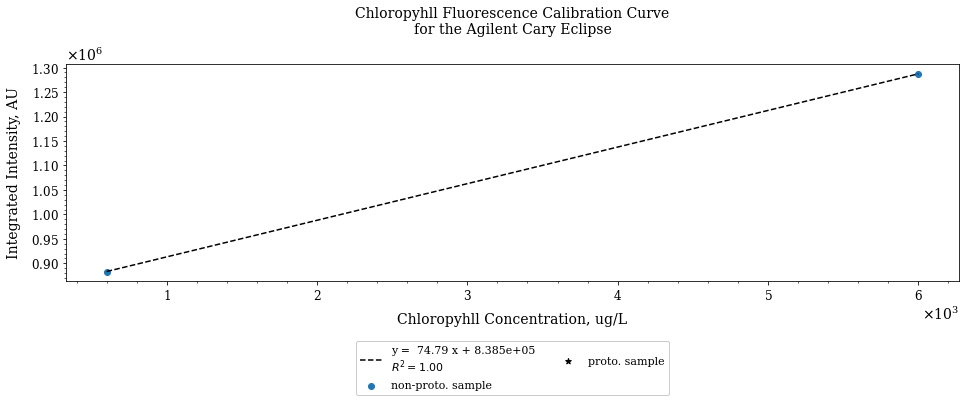

In [24]:
axes = pyeem.plots.calibration_curves_plot(
    dataset, cal_df
)
plt.show()

In [ ]:
display(dataset.meta_df)

In [ ]:
proto_results_df = pyeem.augmentation.create_prototypical_spectra(
    dataset,
    cal_df
)
display(proto_results_df)

In [ ]:
axes = pyeem.plots.prototypical_spectra_plot(
    dataset,
    proto_results_df,
    plot_type="contour"
)
plt.show()

In [ ]:
ss_results_df = pyeem.augmentation.create_single_source_spectra(
    dataset,
    cal_df,
    conc_range=(0, 5000000),
    num_spectra=10
)
display(ss_results_df)

In [ ]:
from IPython.display import HTML
%matplotlib inline

source = "Chlorella"
anim = pyeem.plots.single_source_animation(
    dataset,
    ss_results_df,
    source=source,
    plot_type="imshow",
    fig_kws={"dpi": 120},
    animate_kws={"interval": 100, "blit": True},
)
HTML(anim.to_html5_video())

In [ ]:
data_dir = "../../../../local_test_data/early_test_tecan/tecan_raw"

In [ ]:
metadata_fp = os.path.join(data_dir, "metadata.csv")
meta_df = pd.read_csv(metadata_fp)

In [ ]:
import numpy as np

for name, group in meta_df.groupby("filename"):
    fp = os.path.join(data_dir, name)
    # Read in raw Tecan Spark data with index column equal to zero
    # and skipping the last row of data which contains End Time
    df = pd.read_excel(fp, index_col=0, skipfooter=1)
    # Drop columns and rows with all NaN values, these sometimes
    # appear at the end for some reason
    df.dropna(how="all", axis=1, inplace=True)
    df.dropna(how="all", axis=0, inplace=True)
    group["next_well"] = group['well_id'].shift(-1)

    for index, row in group.iterrows():
        display(row)
        tmp_df = df.loc[row["well_id"]:]
        if not pd.isna(row["next_well"]):
            tmp_df = df.loc[row["well_id"] : row["next_well"]].iloc[:-1]

        new_header = tmp_df.iloc[0] #grab the first row for the header
        tmp_df = tmp_df[1:] #take the data less the header row
        tmp_df.columns = new_header #set the header row as the df header
        tmp_df.index.name = None
        tmp_df.columns.name = None
        display(tmp_df.head())
